# *Merged Jupyter Notebook*

<hr><font color="green"><h1>from file: 1.01 Getting Links</h1></font>

# Getting all NBA players links and names

**Imports**

In [2]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.select import Select
import time
import re

**Main Script**

In [ ]:
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=options)
url = 'https://www.nba.com/players'
driver.get(url)

# Find the toggler element
element = driver.find_elements(By.CSS_SELECTOR, '.Toggle_switch__kRCjc')
element = element[1]

# Get the position of the element
x = element.location['x']
y = element.location['y']

# Create an ActionChains object and move the cursor to the position of the element
action = ActionChains(driver)
action.move_by_offset(x, y)

# Click on the element
action.click()
action.perform()
time.sleep(1)

# Select 'All' in the dropdown list
select_element = driver.find_element(By.XPATH, '//*[@title="Page Number Selection Drown Down List"]')
select = Select(select_element)
select.select_by_visible_text('All')

time.sleep(1)

# Wait for the table to load
wait = WebDriverWait(driver, 15)
wait.until(lambda driver: len(driver.find_elements(By.XPATH, "//table//tbody/tr")) > 1)

# Read the data from the table
table = driver.find_element(By.XPATH, "//table")
data = pd.read_html(table.get_attribute('outerHTML'))[0]

# Find the player names and links
parent = table.find_elements(By.XPATH, "//td[contains(@class, 'primary') and contains(@class, 'text') and contains(@class, 'RosterRow_primaryCol__1lto4')]")
player_data = []
for index, row in data.iterrows():
    name = row['Player']
    formatted_name = re.sub(r"(\w)([A-Z])", r"\1 \2", name).title()
    link = parent[index].find_element(By.TAG_NAME, "a").get_attribute("href")
    
    if "career" not in link:
        player_id = link.split("/")[4]
        new_url = f'https://www.nba.com/stats/player/{player_id}/career'
        player_data.append([formatted_name, new_url])
    else:
        player_data.append([formatted_name, link])

# Save the data to a file
player_df = pd.DataFrame(player_data, columns=['Name', 'Link'])
player_df.to_csv('nba_players_2.csv', index=False)

# Close the driver
driver.quit()

**Showing the file:**

In [3]:
df = pd.read_csv('nba_players_2.csv')
df

,Name,Link
0,Alaa Abdelnaby,https://www.nba.com/stats/player/76001/career/
1,Zaid Abdul-Aziz,https://www.nba.com/stats/player/76002/career/
2,Kareem Abdul-Jabbar,https://www.nba.com/stats/player/76003/career/
3,Mahmoud Abdul-Rauf,https://www.nba.com/stats/player/51/career/
4,Tariq Abdul-Wahad,https://www.nba.com/stats/player/1505/career/
...,...,...
4815,Ante Zizic,https://www.nba.com/stats/player/1627790/career/
4816,Jim Zoet,https://www.nba.com/stats/player/78647/career/
4817,Bill Zopf,https://www.nba.com/stats/player/78648/career/
4818,Ivica Zubac,https://www.nba.com/stats/player/1627826/career/


<hr><font color="green"><h1>from file: 1.02 NBA HOF Prediction</h1></font>

# Players Data #
* **imports**

In [101]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.select import Select
import time
import re

* **Selenium** - function to open a browser and retrieve it's page source in order to use it with Beautiful Soup.

In [9]:
def selenium(link):
    options = webdriver.ChromeOptions()
    options.add_argument("--disable-extensions")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("--remote-debugging-port=9222")
    options.add_argument("--window-size=1920x1080")
    driver = webdriver.Chrome(options=options)
    driver.get(link)
    wait = WebDriverWait(driver, 5)
    element = wait.until(EC.presence_of_element_located((By.XPATH, "//*[@id='__next']/div[2]/div[2]/section/div[4]/section[3]/div/div[2]/div[3]/table/tfoot")))
    element = wait.until(EC.presence_of_element_located((By.XPATH, "//*[@id='__next']/div[2]/div[2]/section/div[4]/div/section[1]/div/div/table/tbody/tr[2]/td[1]")))
    s = driver.page_source
    driver.quit()
    return s

**Initialize Variables**
* Creating a dataframe with all the players names and links we created in previous script (using beautiful soup)
* Creating all lists that will be used to store the data later into a new dataframe

In [8]:
# Read CSV file into a pandas DataFrame
df = pd.read_csv('nba_players_2.csv')
player_data = {
    'ppg': [],
    'apg': [],
    'rpg': [],
    'pie': [],
    'height': [],
    'weight': [],
    'country': [],
    'prev_team': [],
    'age': [],
    'bdate': [],
    'draft': [],
    'exp': [],
    'awards': [],
    'name': [],
    'hScore': [],
    'hReb': [],
    'hAssist': [],
    'hSteal': [],
    'hFieldGoal': [],
    'hFreeThrow': [],
    'hThreePoint': [],
    'hBlock': [],
    'hof': [],
    'totalPts': [],
    'totalGames': []
}

**The main script.**
* Using Selenium to retrieve page source since the page is dynamic.
* Retrieving each NBA player's data one by one with Selenium (total of 4820).
* Saving each data in a unique list.
* Handling Selenium not opening correct page sometimes.
* Handling non-active players not having their age displayed on the page.


In [6]:
### Loop through each row of the DataFrame ###

for index, row in df.iterrows():
    hof_flag = False
    counter = 0 # --> counting opening player's NBA page
    print(index)
    try:
        link = row['Link'] + "?PerMode=Totals"  # --> Get link from row, adding the mode = totals
        
        # Create Beautiful Soup object
        while True:
            if(counter > 5):
                raise Exception("Too many tries")
            temp = selenium(link)
            soup = BeautifulSoup(temp, 'html.parser')
            if soup("div" ,{"class":"Block_blockContent__6iJ_n 0px"}):
                break
            else:
                time.sleep(2)
                count += 1
    except:
        print("Fail to open")
        
    
    ### Fetching First and Last name ###
    
    try:
        firstName = soup("p" ,{"class":"PlayerSummary_playerNameText___MhqC"})[0].get_text()
        lastName = soup("p" ,{"class":"PlayerSummary_playerNameText___MhqC"})[1].get_text()
        player_date['name'].append(f'{firstName} {lastName}')
    except:
        print("Fail to find name")
        
        
    ### Fetching Career Totals ###
    
    try:
        careerSoup = soup("tfoot" ,{"class":"Crom_footer__6iyse"})[0]
        totalGames.append(careerSoup("td")[3].get_text())
        totalPts.append(careerSoup("td")[6].get_text())
    except:
        print("Fail to find career totals")    
        
        
    ### Fetching Total Awards and if is Hall of Fame ###
    
    sum_awards = 0
    try: 
        awardsSoup = soup("div" ,{"class":"Block_blockContent__6iJ_n 0px"})[-1]

        for div in awardsSoup("div",{"class":"PlayerStatsCareer_row___1XFs py-2 px-3"}):
            x = div("span")[0].get_text()
            if 'Hall of Fame' in x:
                hof_flag = True
            sum_awards += int(x('strong').get_text())
    except:
        print("Failed with HOF")
        
    player_data['hof'].append(hof_flag)
    player_data['awards'].append(sum_awards)

     # Get the ppg,aps,rpg,pie
    player_data['ppg'].append(soup("p" ,{"class":"PlayerSummary_playerStatValue___EDg_"})[0].get_text())
    player_data['rpg'].append(soup("p" ,{"class":"PlayerSummary_playerStatValue___EDg_"})[1].get_text())
    player_data['apg'].append(soup("p" ,{"class":"PlayerSummary_playerStatValue___EDg_"})[2].get_text())
    try:
        player_data['pie'].append(soup("p" ,{"class":"PlayerSummary_playerStatValue___EDg_"})[3].get_text())
    except:
        print("failed to find pie")
        
    
    ### Fetching Basic Information About The Player ###
    
    lenP = len(soup("p" ,{"class":"PlayerSummary_playerInfoValue__JS8_v"}))
    for i in range(7):
        temp = soup("p" ,{"class":"PlayerSummary_playerInfoLabel__hb5fs"})[i].get_text()
        if temp == "HEIGHT":
            player_data['height'].append(soup("p" ,{"class":"PlayerSummary_playerInfoValue__JS8_v"})[i].get_text())
        elif temp == "WEIGHT":
            player_data['weight'].append(soup("p" ,{"class":"PlayerSummary_playerInfoValue__JS8_v"})[i].get_text())
        elif temp == "COUNTRY":
            player_data['country'].append(soup("p" ,{"class":"PlayerSummary_playerInfoValue__JS8_v"})[i].get_text())
        elif temp == "LAST ATTENDED":
            player_data['prev_team'].append(soup("p" ,{"class":"PlayerSummary_playerInfoValue__JS8_v"})[i].get_text())
        elif temp == "AGE":
            player_data['age'].append(soup("p" ,{"class":"PlayerSummary_playerInfoValue__JS8_v"})[i].get_text())
        elif temp == "BIRTHDATE":
            player_data['bdate'].append(soup("p" ,{"class":"PlayerSummary_playerInfoValue__JS8_v"})[i].get_text())
        elif temp == "DRAFT":
            player_data['draft'].append(soup("p" ,{"class":"PlayerSummary_playerInfoValue__JS8_v"})[i].get_text())
        elif temp == "EXPERIENCE":
            player_data['exp'].append(soup("p" ,{"class":"PlayerSummary_playerInfoValue__JS8_v"})[i].get_text())

    # age data is missing in the page       
    if lenP == 12:
        player_data['age'].append("--")
    else:
        player_data['exp'].append(soup("p" ,{"class":"PlayerSummary_playerInfoValue__JS8_v"})[7].get_text())

        
        ### Career Highs (points, assists, rebounds...) ###
        
    try:
        highSoup = soup("table" ,{"class":"table border-yellow border-b w-full"})[0]
        for tr in highSoup("tr",{"class":"PlayerStatsCareer_row___1XFs"}):
            if(tr("td" ,{"class":"p-2 text-sm"})[0].get_text() == "Points "):
                try:
                    if(len(tr("strong")) == 1):
                        player_data['hScore'].append(tr("strong")[0].get_text())
                    else:
                        player_data['hScore'].append(tr("strong")[1].get_text())
                except:
                    print("failed with high parmenters.")
                    
            if(tr("td" ,{"class":"p-2 text-sm"})[0].get_text() == "Rebounds "):
                try:
                    if(len(tr("strong")) == 1):
                        player_data['hReb'].append(tr("strong")[0].get_text())
                    else:
                        player_data['hReb'].append(tr("strong")[1].get_text())
                except:
                    print("failed with high parmenters.")

            
            if(tr("td" ,{"class":"p-2 text-sm"})[0].get_text() == "Assists "):
                try:
                    if(len(tr("strong")) == 1):
                        player_data['hAssist'].append(tr("strong")[0].get_text())
                    else:
                        player_data['hAssist'].append(tr("strong")[1].get_text())
                except:
                    print("failed with high parmenters.")
                    
                    
            if(tr("td" ,{"class":"p-2 text-sm"})[0].get_text() == "Steals "):
                try:
                    if(len(tr("strong")) == 1):
                        player_data['hSteal'].append(tr("strong")[0].get_text())
                    else:
                        player_data['hSteal'].append(tr("strong")[1].get_text())
                except:
                    print("failed with high parmenters.")
                    
            if(tr("td" ,{"class":"p-2 text-sm"})[0].get_text() == "Field Goals Made"):
                try:
                    if(len(tr("strong")) == 1):
                        player_data['hFieldGoal'].append(tr("strong")[0].get_text())
                    else:
                        player_data['hFieldGoal'].append(tr("strong")[1].get_text())
                except:
                    print("failed with high parmenters.")
                    
                    
            if(tr("td" ,{"class":"p-2 text-sm"})[0].get_text() == "Free Throws Made"):
                try:
                    if(len(tr("strong")) == 1):
                        player_data['hFreeThrow'].append(tr("strong")[0].get_text())
                    else:
                        player_data['hFreeThrow'].append(tr("strong")[1].get_text())
                except:
                    print("failed with high parmenters.")
                    
                    
            if(tr("td" ,{"class":"p-2 text-sm"})[0].get_text() == "Three Pointers Made"):
                try:
                    if(len(tr("strong")) == 1):
                        player_data['hThreePoint'].append(tr("strong")[0].get_text())
                    else:
                        player_data['hThreePoint'].append(tr("strong")[1].get_text())
                except:
                    print("failed with high parmenters.")

                    
            if(tr("td" ,{"class":"p-2 text-sm"})[0].get_text() == "Blocks"):
                try:
                    if(len(tr("strong")) == 1):
                        player_data['hBlock'].append(tr("strong")[0].get_text())
                    else:
                        player_data['hBlock'].append(tr("strong")[1].get_text())
                except:
                    print("failed with high parmenters.")
                    
    except:
        print("Failed With Highes")
        
    ### <------  end of fetching Career Highs -------> ###
        
        
    ### Adding missing values ###    
    
    for value in player_data.values():
        if len(value) != index+1:
            value.append('--')            

0
Fail to find name
Fail to find career totals
failed to find pie
failed with high parmenters.
failed with high parmenters.
1
Fail to find name
Fail to find career totals
failed to find pie
failed with high parmenters.
failed with high parmenters.
2
Fail to find name
Fail to find career totals
Failed with HOF
failed to find pie
failed with high parmenters.
3
Fail to find name
Fail to find career totals
Failed with HOF
failed to find pie
4
Fail to find name
Fail to find career totals
failed to find pie
failed with high parmenters.
5


Exception ignored in: <function Service.__del__ at 0x00000214C5845B20>
Traceback (most recent call last):
  File "D:\Program Files\Python\Lib\site-packages\selenium\webdriver\common\service.py", line 190, in __del__
    self.stop()
  File "D:\Program Files\Python\Lib\site-packages\selenium\webdriver\common\service.py", line 151, in stop
    self.send_remote_shutdown_command()
  File "D:\Program Files\Python\Lib\site-packages\selenium\webdriver\common\service.py", line 130, in send_remote_shutdown_command
    request.urlopen(f"{self.service_url}/shutdown")
  File "D:\Program Files\Python\Lib\urllib\request.py", line 216, in urlopen
    return opener.open(url, data, timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Program Files\Python\Lib\urllib\request.py", line 519, in open
    response = self._open(req, data)
               ^^^^^^^^^^^^^^^^^^^^^
  File "D:\Program Files\Python\Lib\urllib\request.py", line 536, in _open
    result = self._call_chain(self.handle_open, prot

Fail to open
Fail to find name
Fail to find career totals
failed to find pie
Failed With Highes
6
Fail to open


Exception ignored in: <function Service.__del__ at 0x00000214C5845B20>
Traceback (most recent call last):
  File "D:\Program Files\Python\Lib\site-packages\selenium\webdriver\common\service.py", line 190, in __del__
    self.stop()
  File "D:\Program Files\Python\Lib\site-packages\selenium\webdriver\common\service.py", line 151, in stop
    self.send_remote_shutdown_command()
  File "D:\Program Files\Python\Lib\site-packages\selenium\webdriver\common\service.py", line 135, in send_remote_shutdown_command
    if not self.is_connectable():
           ^^^^^^^^^^^^^^^^^^^^^
  File "D:\Program Files\Python\Lib\site-packages\selenium\webdriver\common\service.py", line 124, in is_connectable
    return utils.is_connectable(self.port)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Program Files\Python\Lib\site-packages\selenium\webdriver\common\utils.py", line 102, in is_connectable
    socket_ = socket.create_connection((host, port), 1)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Fail to find name
Fail to find career totals
Failed with HOF
failed to find pie
failed with high parmenters.
7
Fail to open
Fail to find name
Fail to find career totals
failed to find pie
failed with high parmenters.
8
Fail to open
Fail to find name
Fail to find career totals
failed to find pie
failed with high parmenters.
9
Fail to open
Fail to find name
Fail to find career totals
failed to find pie
failed with high parmenters.


 **Saving the new data**

After collecting all the data from NBA.com we needed to create a new dataframe with all the new data and add it to our previous data.
* Used pd.concat to merge the 2 different dataframes.

In [5]:
# creating a data frame with all the scraped data

df_new = pd.DataFrame({
  'Name': player_data['name'],
  'Points': player_data['ppg'],
  'Asists': player_data['apg'],
  'Rebound': player_data['rpg'],
  'Pie': player_data['pie'],
  'Height': player_data['height'],
  'Weight': player_data['weight'],
  'Country': player_data['country'],
  'Previous Team': player_data['prev_team'],
  'Age': player_data['age'],
  'Birthdate': player_data['bdate'],
  'Draft': player_data['draft'],
  'Experience': player_data['exp'],
  'Total Awards': player_data['awards'],
  'High Score': player_data['hScore'],
  'High Rebound': player_data['hReb'],
  'High Assist': player_data['hAssist'],
  'High Steal': player_data['hSteal'],
  'High Field Goals': player_data['hFieldGoal'],
  'High Free Throws': player_data['hFreeThrow'],
  'High Three Pointers': player_data['hThreePoint'],
  'High Block': player_data['hBlock'],
  'Total Points': player_data['totalPts'],
  'Total Games': player_data['totalGames']
})

# Export the dataframe to a csv file
df = pd.concat([df, df_new], axis = 1)
df.to_csv('nba_players_scraped.csv', index=False)

# API Request


**Player's Position**
* Fetching player's playing position using an API

**Initialize Variables**

In [7]:
df_old = pd.read_csv('nba_players_scraped.csv')
Position = []

**Main Script**

In [ ]:
for index, row in df.iterrows():
    player = row['Name']
    url = "https://balldontlie.io/api/v1/players?search=" + player
    responseJson = requests.get(url)
    response = responseJson.json()
    data = response['data']
    if type(data) == list:
        position = data[0]['position']
    else:
        position = data['position']
    Position.append(position)

**Saving Position to the CSV file**

In [ ]:
df_pos = pd.DataFrame({'Position': Position})
df = pd.concat([df_old, df_pos], axis = 1)
df.to_csv('nba_players_scraped.csv', index=False)

<hr><font color="green"><h1>from file: 1.03 Data Cleaning</h1></font>

# Data Cleaning

**Imports**

In [68]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

**Loading the Data**

In [69]:
df = pd.read_csv("nba_players_scraped.csv")
df

,Index,Name,Position,High Score,High Rebound,High Assist,High Steal,High Field Goals,High Free Throes,High Three Pointers,...,Pie,Height,Weight,Country,Previous Team,Age,Birthdate,Draft,Experience,Total Awards
0,1,Alaa Abdelnaby,Forward,8,6,1,--,4,1,--,...,--,"6'10"" (2.08m)",240lb (109kg),USA,Duke,--,"June 24, 1968",1990 R1 Pick 25,5 Years,0
1,2,Zaid Abdul-Aziz,Center,22,8,2,--,8,6,--,...,--,"6'9"" (2.06m)",235lb (107kg),USA,Iowa State,--,"April 7, 1946",1968 R1 Pick 5,10 Years,0
2,3,Kareem Abdul-Jabbar,Center,46,26,11,6,20,13,--,...,--,"7'2"" (2.18m)",225lb (102kg),USA,UCLA,--,"April 16, 1947",1969 R1 Pick 1,20 Years,53
3,4,Mahmoud Abdul-Rauf,Guard,23,4,6,1,9,6,3,...,--,"6'1"" (1.85m)",162lb (73kg),USA,Louisiana State,--,"March 9, 1969",1990 R1 Pick 3,9 Years,2
4,5,Tariq Abdul-Wahad,Forward-Guard,16,6,4,3,5,6,--,...,--,"6'6"" (1.98m)",235lb (107kg),France,San Jose State,--,"November 3, 1974",1997 R1 Pick 11,7 Years,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4815,4816,Ante Zizic,Center,4,2,1,--,2,2,--,...,--,"6'10"" (2.08m)",266lb (121kg),Croatia,Darussafaka,--,"January 4, 1997",2016 R1 Pick 23,4 Years,0
4816,4817,Jim Zoet,Center,--,--,--,--,--,--,--,...,--,"7'1"" (2.16m)",240lb (109kg),USA,Kent State,--,"December 30, 1953",Undrafted,1 Year,0
4817,4818,Bill Zopf,Guard,--,--,--,--,--,--,--,...,--,"6'1"" (1.85m)",170lb (77kg),USA,Duquesne,--,"June 7, 1948",1970 R2 Pick 33,1 Year,0
4818,4819,Ivica Zubac,Center,18,16,3,2,8,9,--,...,10.9,"7'0"" (2.13m)",240lb (109kg),Croatia,Mega Basket,26 years,"March 18, 1997",2016 R2 Pick 32,6 Years,0


**Extracting the draft and converting it to Year, Round, and Pick**

In [70]:
def extract_draft(draft_str):
    if draft_str == 'Undrafted':
        return [-1, -1, -1]
    draft_parts = draft_str.split(' ')
    year = int(draft_parts[0])
    if len(draft_parts) == 1:
        round_num = -1
        pick_num = -1
    else:
        round_str = draft_parts[1]
        pick_str = draft_parts[-1]
        if round_str == '':
            round_num = -1
        else:
            round_num = int(round_str[1:])
        if pick_str == '':
            pick_num = -1
        else:
            pick_num = int(pick_str)
    return [year, round_num, pick_num]

**Converting Experience to Years Only (int)**

In [71]:
def experience_to_num(experience):
    if experience == "Rookie":
        return 0
    return int(experience.split(' ')[0])

**Converting Birthdate to Birth year only**

In [72]:
def birthYear(birthdate):
    return int(birthdate.split(',')[1].strip())

**Filling/Removing Missing Values**

In [73]:
### Replacing all'--' with Null value ###
df_new = df.replace("--", None).copy()

# Removing Age and Pie columns
df_new.drop(['Age', 'Pie'], axis = 1, inplace=True)

### Fetching First and Last name ###
df_new['High Score'].fillna(0, inplace = True)
df_new['High Rebound'].fillna(0, inplace = True)
df_new['High Assist'].fillna(0, inplace = True)
df_new['High Steal'].fillna(0, inplace = True)
df_new['High Field Goals'].fillna(0, inplace = True)
df_new['High Free Throes'].fillna(0, inplace = True)
df_new['High Three Pointers'].fillna(0, inplace = True)
df_new['High Block'].fillna(0, inplace = True)

#
df_new.dropna(axis = 0, thresh=23, inplace=True)

###
df_new['Rebound'].fillna(0, inplace = True)
df_new['Height'] = df_new['Height'].str.extract(r'(\d+\.\d+)', expand=False).astype(float)
df_new['Height'].fillna(df_new['Height'].mean(), inplace = True)
df_new['Weight'] = df_new['Weight'].str.extract(r'(\d+)kg', expand=False).astype(float)
df_new['Weight'].fillna(df_new['Weight'].mean(), inplace = True)
df_new['Asists'].fillna(0, inplace = True)


###
df_new.dropna(axis='index', how='any', subset=['Points'], inplace=True)
df_new.Position.fillna('--', inplace=True)
df_new[['Draft Year', 'Draft Round', 'Draft Pick']] = df_new['Draft'].apply(extract_draft).tolist()
df_new.drop(['Draft'], axis=1, inplace=True)


###
df_new['Experience'] = df_new['Experience'].apply(experience_to_num)

###
df_new['Birthdate'] = df_new['Birthdate'].apply(birthYear)


### Converting country to code ###


df_new

,Index,Name,Position,High Score,High Rebound,High Assist,High Steal,High Field Goals,High Free Throes,High Three Pointers,...,Height,Weight,Country,Previous Team,Birthdate,Experience,Total Awards,Draft Year,Draft Round,Draft Pick
0,1,Alaa Abdelnaby,Forward,8,6,1,0,4,1,0,...,2.08,109.0,USA,Duke,1968,5,0,1990,1,25
1,2,Zaid Abdul-Aziz,Center,22,8,2,0,8,6,0,...,2.06,107.0,USA,Iowa State,1946,10,0,1968,1,5
2,3,Kareem Abdul-Jabbar,Center,46,26,11,6,20,13,0,...,2.18,102.0,USA,UCLA,1947,20,53,1969,1,1
3,4,Mahmoud Abdul-Rauf,Guard,23,4,6,1,9,6,3,...,1.85,73.0,USA,Louisiana State,1969,9,2,1990,1,3
4,5,Tariq Abdul-Wahad,Forward-Guard,16,6,4,3,5,6,0,...,1.98,107.0,France,San Jose State,1974,7,0,1997,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4815,4816,Ante Zizic,Center,4,2,1,0,2,2,0,...,2.08,121.0,Croatia,Darussafaka,1997,4,0,2016,1,23
4816,4817,Jim Zoet,Center,0,0,0,0,0,0,0,...,2.16,109.0,USA,Kent State,1953,1,0,-1,-1,-1
4817,4818,Bill Zopf,Guard,0,0,0,0,0,0,0,...,1.85,77.0,USA,Duquesne,1948,1,0,1970,2,33
4818,4819,Ivica Zubac,Center,18,16,3,2,8,9,0,...,2.13,109.0,Croatia,Mega Basket,1997,6,0,2016,2,32


**Remove duplicates**

In [74]:
df_new.drop_duplicates(subset=['Name'], keep='first', inplace=True)
df_new

,Index,Name,Position,High Score,High Rebound,High Assist,High Steal,High Field Goals,High Free Throes,High Three Pointers,...,Height,Weight,Country,Previous Team,Birthdate,Experience,Total Awards,Draft Year,Draft Round,Draft Pick
0,1,Alaa Abdelnaby,Forward,8,6,1,0,4,1,0,...,2.08,109.0,USA,Duke,1968,5,0,1990,1,25
1,2,Zaid Abdul-Aziz,Center,22,8,2,0,8,6,0,...,2.06,107.0,USA,Iowa State,1946,10,0,1968,1,5
2,3,Kareem Abdul-Jabbar,Center,46,26,11,6,20,13,0,...,2.18,102.0,USA,UCLA,1947,20,53,1969,1,1
3,4,Mahmoud Abdul-Rauf,Guard,23,4,6,1,9,6,3,...,1.85,73.0,USA,Louisiana State,1969,9,2,1990,1,3
4,5,Tariq Abdul-Wahad,Forward-Guard,16,6,4,3,5,6,0,...,1.98,107.0,France,San Jose State,1974,7,0,1997,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4815,4816,Ante Zizic,Center,4,2,1,0,2,2,0,...,2.08,121.0,Croatia,Darussafaka,1997,4,0,2016,1,23
4816,4817,Jim Zoet,Center,0,0,0,0,0,0,0,...,2.16,109.0,USA,Kent State,1953,1,0,-1,-1,-1
4817,4818,Bill Zopf,Guard,0,0,0,0,0,0,0,...,1.85,77.0,USA,Duquesne,1948,1,0,1970,2,33
4818,4819,Ivica Zubac,Center,18,16,3,2,8,9,0,...,2.13,109.0,Croatia,Mega Basket,1997,6,0,2016,2,32


**List of country codes**

USA: 63 | France: 25 | Spain: 67 | Nigeria: 49 | New Zealand: 44 | South Sudan: 61 | Trinidad and Tobago: 69 | Turkey: 70 | Canada: 11 | United Kingdom: 75 | Australia: 3 | Greece: 24 | Macedonia: 38 | Brazil: 7 | Scotland: 64 | Puerto Rico: 53 | Israel: 33 | Bahamas: 5 | Croatia: 13 | Italy: 35 | China: 10 | Uruguay: 74 | Russia: 55 | US Virgin Islands: 72 | Latvia: 36 | Georgia: 23 | DRC: 16 | Serbia: 66 | Sudan: 62 | Argentina: 1 | Ukraine: 71 | Germany: 21 | Cuba: 14 | Saint Lucia: 60 | Slovenia: 68 | Norway: 48 | Ireland: 32 | Switzerland: 65 | Haiti: 29 | Dominican Republic: 17 | Guinea: 26 | Mali: 40 | Senegal: 59 | Netherlands: 46 | Cameroon: 9 | Jamaica: 34 | Congo: 12 | Angola: 0 | Panama: 50 | St. Vincent & Grenadines: 58 | Bulgaria: 6 | Poland: 52 | Mexico: 42 | South Korea: 57 | Japan: 37 | Iran: 31 | Democratic Republic of the Congo: 15 | Lithuania: 41 | Sweden: 63 | Czech Republic: 18 | Gabon: 20 | Denmark: 19 | Finland: 27 | Belgium: 4 | Tunisia: 73 | Montenegro: 43 | Romania: 56 | Bosnia and Herzegovina: 8 | Estonia: 22 | Egypt: 28 | Belize: 2 | Antigua and Barbuda: 70 | Austria: 2 | Portugal: 54 | Cabo Verde: 69 | Tanzania: 72 | Venezuela: 76 

**Converting object columns to int**

In [75]:
df_new['High Score'] = df_new['High Score'].astype('int64')
df_new['High Rebound'] = df_new['High Rebound'].astype('int64')
df_new['High Assist'] = df_new['High Assist'].astype('int64')
df_new['High Steal'] = df_new['High Steal'].astype('int64')
df_new['High Field Goals'] = df_new['High Field Goals'].astype('int64')
df_new['High Free Throes'] = df_new['High Free Throes'].astype('int64')
df_new['High Three Pointers'] = df_new['High Three Pointers'].astype('int64')
df_new['High Block'] = df_new['High Block'].astype('int64')
df_new['Points'] = df_new['Points'].astype('float64')
df_new['Asists'] = df_new['Asists'].astype('float64')
df_new['Rebound'] = df_new['Rebound'].astype('float64')
df_new.drop(['Name'], axis = 1, inplace=True)

**Using Label Encoder**

In [76]:
le = LabelEncoder()
# Fit the encoder on the country column and transform it into numerical values
df_new['Country'] = le.fit_transform(df_new['Country']).astype('int64')
df_new['Previous Team'] = le.fit_transform(df_new['Previous Team']).astype('int64')
df_new['Position'] = le.fit_transform(df_new['Position']).astype('int64')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4526 entries, 0 to 4819
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Index                4526 non-null   int64  
 1   Position             4526 non-null   int64  
 2   High Score           4526 non-null   int64  
 3   High Rebound         4526 non-null   int64  
 4   High Assist          4526 non-null   int64  
 5   High Steal           4526 non-null   int64  
 6   High Field Goals     4526 non-null   int64  
 7   High Free Throes     4526 non-null   int64  
 8   High Three Pointers  4526 non-null   int64  
 9   High Block           4526 non-null   int64  
 10  Total Games          4526 non-null   int64  
 11  Total Points         4526 non-null   int64  
 12  Hall Of Famer        4526 non-null   bool   
 13  Points               4526 non-null   float64
 14  Asists               4526 non-null   float64
 15  Rebound              4526 non-null   float6

In [77]:
df_new.Position.unique()

array([3, 1, 6, 5, 0, 2, 4, 7], dtype=int64)

# Handling <span style="color:darkred">Outliers</span>
* You can see that players with less than 10 games have no chance to get into hall of fame, so we removed them.

Text(0, 0.5, 'Frequency')

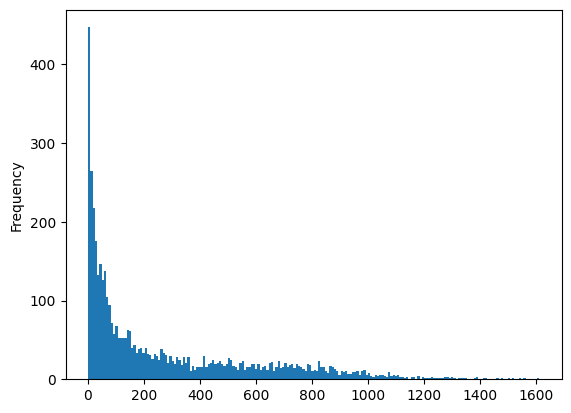

In [78]:
plt.hist(df_new['Total Games'], bins=200)
plt.xlabel=("Games")
plt.ylabel("Frequency")


In [79]:
df_new[df_new['Total Games'] < 10] = np.nan
df_new['Total Games'].describe()

count    4079.000000
mean      309.502084
std       315.315140
min        10.000000
25%        54.000000
50%       177.000000
75%       508.500000
max      1611.000000
Name: Total Games, dtype: float64

In [80]:
df_new.dropna(axis=0, how='all', inplace=True)
df_new

,Index,Position,High Score,High Rebound,High Assist,High Steal,High Field Goals,High Free Throes,High Three Pointers,High Block,...,Height,Weight,Country,Previous Team,Birthdate,Experience,Total Awards,Draft Year,Draft Round,Draft Pick
0,1.0,3.0,8.0,6.0,1.0,0.0,4.0,1.0,0.0,1.0,...,2.08,109.0,72.0,163.0,1968.0,5.0,0.0,1990.0,1.0,25.0
1,2.0,1.0,22.0,8.0,2.0,0.0,8.0,6.0,0.0,2.0,...,2.06,107.0,72.0,263.0,1946.0,10.0,0.0,1968.0,1.0,5.0
2,3.0,1.0,46.0,26.0,11.0,6.0,20.0,13.0,0.0,9.0,...,2.18,102.0,72.0,577.0,1947.0,20.0,53.0,1969.0,1.0,1.0
3,4.0,6.0,23.0,4.0,6.0,1.0,9.0,6.0,3.0,1.0,...,1.85,73.0,72.0,300.0,1969.0,9.0,2.0,1990.0,1.0,3.0
4,5.0,5.0,16.0,6.0,4.0,3.0,5.0,6.0,0.0,1.0,...,1.98,107.0,26.0,472.0,1974.0,7.0,0.0,1997.0,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4814,4815.0,3.0,16.0,6.0,1.0,1.0,6.0,4.0,2.0,1.0,...,2.03,103.0,29.0,43.0,1994.0,2.0,0.0,2016.0,2.0,48.0
4815,4816.0,1.0,4.0,2.0,1.0,0.0,2.0,2.0,0.0,1.0,...,2.08,121.0,16.0,144.0,1997.0,4.0,0.0,2016.0,1.0,23.0
4817,4818.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.85,77.0,72.0,164.0,1948.0,1.0,0.0,1970.0,2.0,33.0
4818,4819.0,1.0,18.0,16.0,3.0,2.0,8.0,9.0,0.0,3.0,...,2.13,109.0,16.0,322.0,1997.0,6.0,0.0,2016.0,2.0,32.0


**Saving File**

In [83]:
df_new.to_csv("final_player_data.csv",index=False)

<hr><font color="green"><h1>from file: 1.04 Data Visualization - EDA</h1></font>

# EDA - Data Visualization

**Imports**

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np


**Loading dataframe into df**

In [64]:
df = pd.read_csv("final_player_data.csv")

<br></br>
<span style="font-size:18px">**Plots - Graphical Represntation**</span>
* <span style ="color:red; font-weight:bold">P-value</span> is **over 0.5**, therefore **no correlation** to hall of famer

In [65]:
ct = pd.crosstab(df['Position'], df['Hall Of Famer'])
chi2_contingency(ct)

Chi2ContingencyResult(statistic=31.480778158621874, pvalue=5.067867774022016e-05, dof=7, expected_freq=array([[ 523.92890414,   18.07109586],
       [ 499.76244177,   17.23755823],
       [  71.53272861,    2.46727139],
       [1246.02279971,   42.97720029],
       [ 101.49914195,    3.50085805],
       [  51.23290022,    1.76709978],
       [1334.95538122,   46.04461878],
       [ 114.06570238,    3.93429762]]))

<br></br><br></br>
* You can see there is a relationship between Total Points and Hall Of Famer

<Axes: xlabel='Total Points', ylabel='Points'>

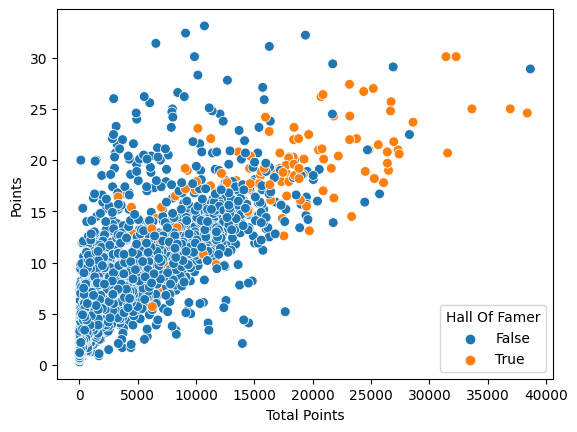

In [66]:
sns.scatterplot(x = 'Total Points',y = 'Points', s=50, hue= 'Hall Of Famer',data = df)

<br></br><br></br>

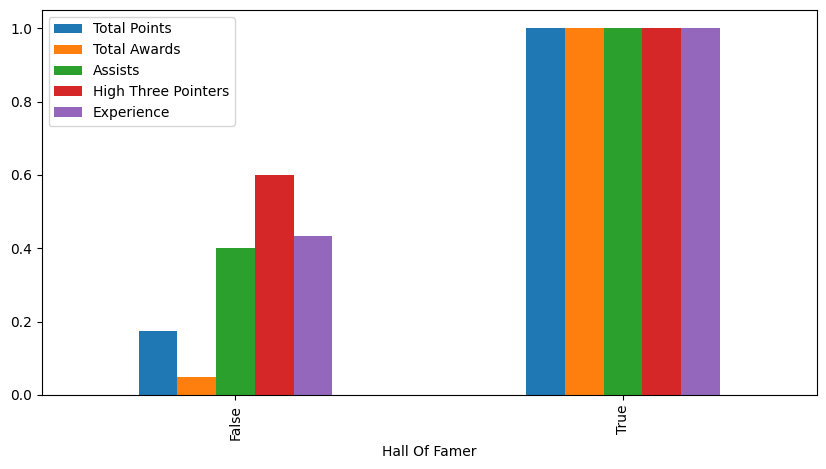

In [67]:
grouped_data = df.groupby('Hall Of Famer')[['Total Points', 'Total Awards', 'Assists', 'High Three Pointers', 'Experience']].mean()

# Normalize the data by dividing each column by its maximum value
normalized_data = grouped_data / grouped_data.max()

normalized_data.plot(kind='bar', figsize=(10, 5))
plt.show()

<br></br><br></br>

**Showing the distribution of the <span style="color:blue">Total Points</span> for Hall Of Famers vs non Hall Of Famers**

<Axes: xlabel='Hall Of Famer', ylabel='Total Points'>

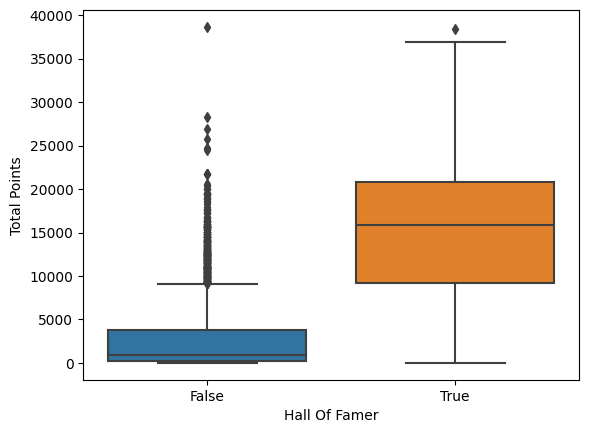

In [68]:
sns.boxplot(x='Hall Of Famer', y='Total Points', data=df)

<br></br><br></br>

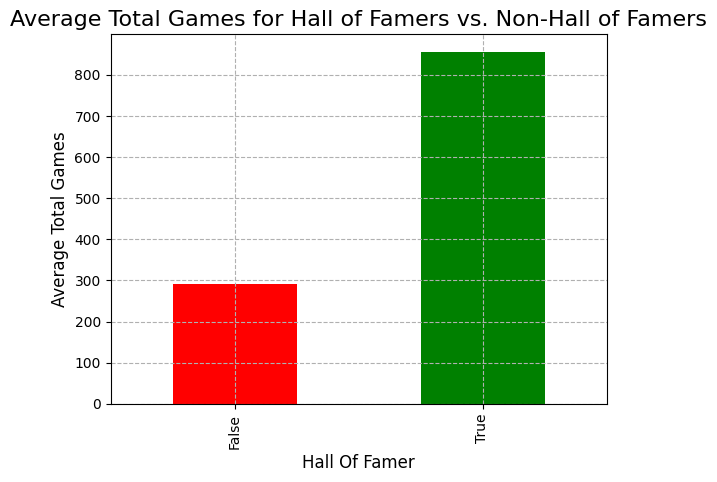

In [69]:
# Calculate the average total games for Hall of Famers and non-Hall of Famers
avg_total_games = df.groupby('Hall Of Famer')['Total Games'].mean()

avg_total_games.plot(kind='bar', color=['red', 'green'])
plt.title('Average Total Games for Hall of Famers vs. Non-Hall of Famers', fontsize=16)
plt.xlabel('Hall Of Famer', fontsize=12)
plt.ylabel('Average Total Games', fontsize=12)
plt.grid(True, linestyle='--')
plt.show()

<br></br><br></br>

<span style="font-size:18px">**Hall Of Famers per Year**</span>

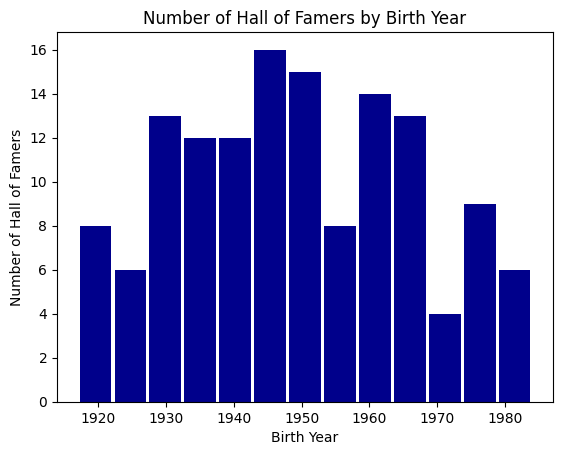

In [70]:
df[df['Hall Of Famer'] == True]['Birthdate'].hist(bins=13, grid=False, rwidth=0.9, color='darkblue')
plt.xlabel('Birth Year')
plt.ylabel('Number of Hall of Famers')
plt.title('Number of Hall of Famers by Birth Year')
plt.show()

<br></br><br></br>
* <span style="font-size:15px"> You can see here that both edges of the lines of Hall Of Famers and non Hall Of Famers are around the 40k. We can infer from  that these are active players which will likely get into the Hall Of Fame list in couple years. </span>

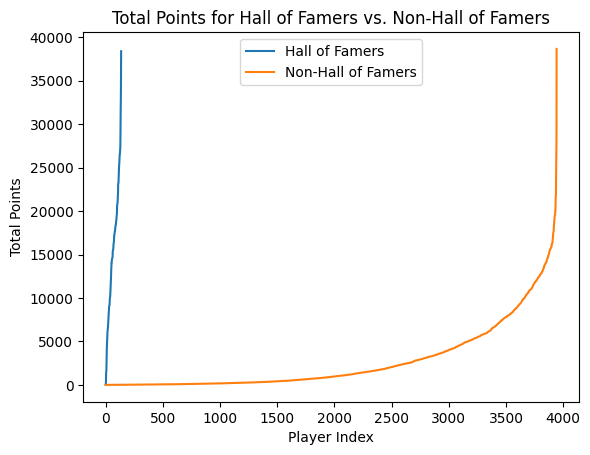

In [71]:
hall_of_famers = df[df['Hall Of Famer'] == True]

hall_of_famers = hall_of_famers.sort_values(by='Total Points')

hall_of_famers = hall_of_famers.reset_index(drop=True)

ax = hall_of_famers.plot(y='Total Points', kind='line', label='Hall of Famers')

non_hall_of_famers = df[df['Hall Of Famer'] == False]

non_hall_of_famers = non_hall_of_famers.sort_values(by='Total Points')

non_hall_of_famers = non_hall_of_famers.reset_index(drop=True)

non_hall_of_famers.plot(y='Total Points', kind='line', label='Non-Hall of Famers', ax=ax)

plt.title('Total Points for Hall of Famers vs. Non-Hall of Famers')
plt.xlabel('Player Index')
plt.ylabel('Total Points')
plt.legend()
plt.show()

<br></br><br></br>
* <span style="font-size:15px">We can see here that most Hall Of Fame players were picked in round 1</span>
* <span style="font-size:15px">Players that were picked after</span>

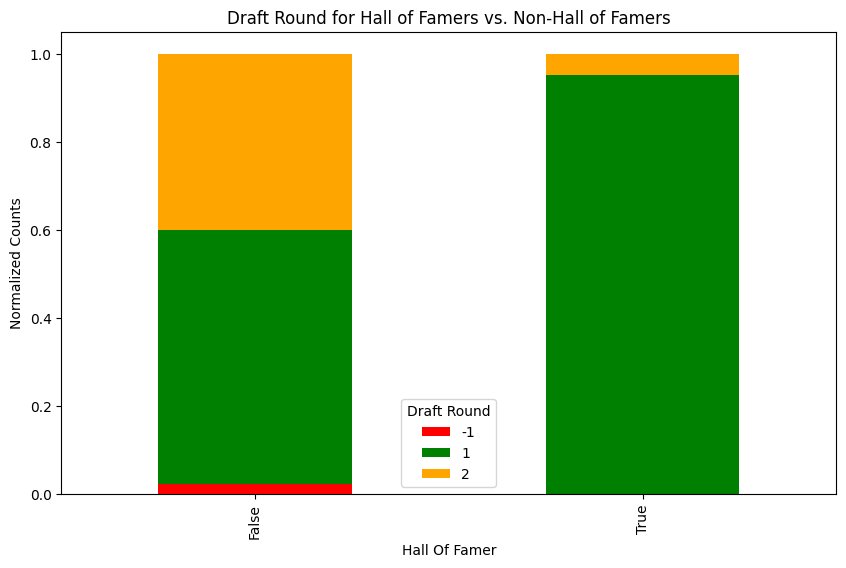

In [72]:
### Taking only relevant players since before year 1989 NBA rules were different 

df_new = df[df['Draft Year'] > 1989]
df_new = df_new[df_new['Draft Round'] != 0]

# Create a cross-tabulation table that shows the normalized counts of players in each draft round for Hall of Famers vs. non-Hall of Famers
ct = pd.crosstab(df_new['Hall Of Famer'], df_new['Draft Round'], normalize='index')

# Create a stacked bar plot to visualize the data
colors = ["red", "green", "orange"]
ct.plot.bar(stacked=True, color=colors, figsize=(10, 6))
plt.xlabel('Hall Of Famer')
plt.ylabel('Normalized Counts')
plt.title('Draft Round for Hall of Famers vs. Non-Hall of Famers')
plt.show()

<br></br><br></br>

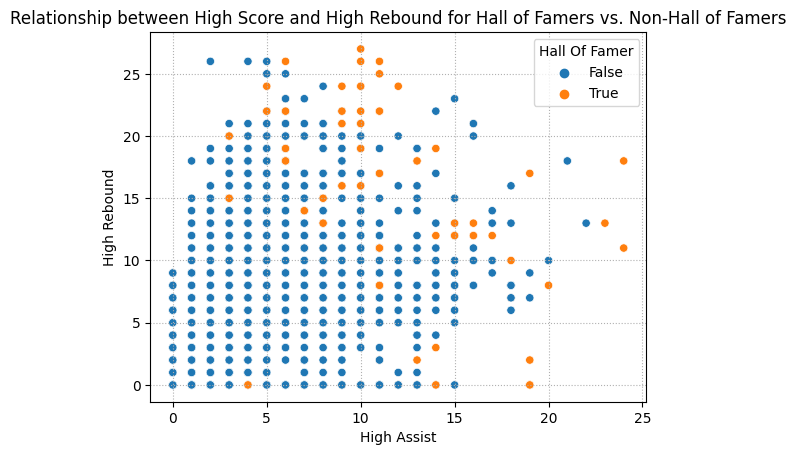

In [73]:
sns.scatterplot(x='High Assist', y='High Rebound', hue='Hall Of Famer', data=df)
plt.title('Relationship between High Score and High Rebound for Hall of Famers vs. Non-Hall of Famers')
plt.grid(True, linestyle=':')
plt.show()

<br></br>

# Heatmap

<Axes: >

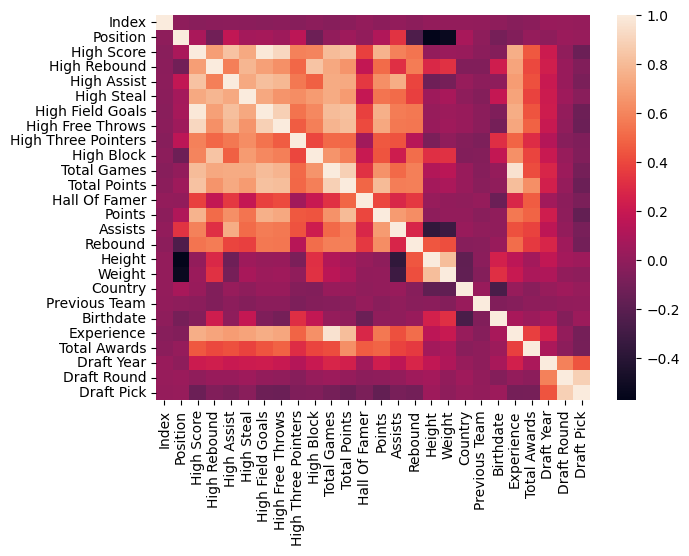

In [74]:
plt.figure(figsize=(7,5))
sns.heatmap(df.corr())

<br></br>

* Found that <span style ="color:red; font-weight:bold">'Experience'</span> and <span style ="color:red; font-weight:bold">'Total Games'</span> columns have high correlation.
* Found that <span style ="color:red; font-weight:bold">'High Field Goals'</span> and <span style ="color:red; font-weight:bold">'High Score'</span> columns have high correlation.

In [75]:
correlation = df['Experience'].corr(df['Total Games'])
print(f"Correlation between Experience and Total Games: {correlation:.2f}")

Correlation between Experience and Total Games: 0.96


In [76]:
correlation = df['High Field Goals'].corr(df['High Score'])
print(f"Correlation between High Field Goals and High Score: {correlation:.2f}")

Correlation between High Field Goals and High Score: 0.99


**Droping columns with high correlation and saving it to a new file**

In [77]:
df.drop(['Experience', 'High Field Goals'], axis=1, inplace=True)
df.to_csv("final_modified_players.csv", index=False)

<hr><font color="green"><h1>from file: 1.05 Machine Learning</h1></font>

# Machine Leraning Algorithms

**Imports**

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
import pandas as pd

**Reading the DataFrame**

In [2]:
df = pd.read_csv("final_modified_players.csv")

<br/>
<br/>

* Function to print model results

In [3]:
def print_results(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')

    precision = precision_score(y_test, y_pred)
    print(f'Precision: {precision}')

    recall = recall_score(y_test, y_pred)
    print(f'Recall: {recall}')

    f1 = f1_score(y_test, y_pred)
    print(f'F1-score: {f1}')

<br/>
<br/>


**Finding Best K for KNN**

In [4]:
def find_best_k_for_KNN(X_train, y_train):
    parameters = {'n_neighbors': list(range(1, 64))}
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters, scoring=make_scorer(metrics.f1_score, greater_is_better=True))
    clf.fit(X_train, y_train)
    best_K = clf.best_params_["n_neighbors"]
    return best_K, clf.best_score_

In [5]:
# Split data into training and test sets
X = df.drop('Hall Of Famer', axis=1)
y = df['Hall Of Famer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Find the best value of k
best_k, best_score = find_best_k_for_KNN(X_train, y_train)
print(f'Best k value: {best_k}')
print(f'Best cross-validated F1-score: {best_score}')

Best k value: 16
Best cross-validated F1-score: 0.4816410256410257


**KNN Model**

In [6]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [7]:
print_results(y_test, y_pred)

Accuracy: 0.9763071895424836
Precision: 0.7142857142857143
Recall: 0.39473684210526316
F1-score: 0.5084745762711864


<br/>
<br/>

**Decision Tree Algorithm without scaler**

In [8]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

In [9]:
print_results(y_test, y_pred)

Accuracy: 0.9771241830065359
Precision: 0.6086956521739131
Recall: 0.7368421052631579
F1-score: 0.6666666666666666


<br/>
<br/>


**Handling binary imbalance calssification using <span style="color:green">SMOTE**</span>

In [10]:
# Separate the features and the target variable
X = df.drop('Hall Of Famer', axis=1)
y = df['Hall Of Famer']

# Create a SMOTE object with a 70/30 ratio
sm = SMOTE(random_state=0, sampling_strategy=0.2)

# Fit the SMOTE object to the data
X_resampled, y_resampled = sm.fit_resample(X, y)

# Check the new class distribution
print(pd.Series(y_resampled).value_counts())

Hall Of Famer
False    3943
True      788
Name: count, dtype: int64


<br/>
<br/>

**Logistic Regression**
* Using logistic regression algorithim with <span style="color:blue">**scaler**</span>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print_results(y_test, y_pred)

Accuracy: 0.9640845070422536
Precision: 0.9137931034482759
Recall: 0.8724279835390947
F1-score: 0.8926315789473684


<br/>


<span style="font-size: 16px">**Checking the impact of <span style="color: blue; font-weight: bold;">Total Points</span> on Hall Of Fame chance**</span>
* Using permutation importance to check how important is total points column for the prediction of hall of famer. The value we got means that the prediction was around **12% worse without total points column.**

In [13]:
# Compute permutation importance
result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10)

feature_index = X.columns.get_loc('Total Points')

print(f'Total Points: {result.importances_mean[feature_index]:.3f} +/- {result.importances_std[feature_index]:.3f}')

Total Points: 0.121 +/- 0.006


<br/>
<br/>

**Decision Tree with Scaler**

In [14]:
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)

y_pred = dt.predict(X_test_scaled)
print_results(y_test, y_pred)

Accuracy: 0.967605633802817
Precision: 0.8893280632411067
Recall: 0.9259259259259259
F1-score: 0.9072580645161291


<Axes: title={'center': 'Feature Importance'}>

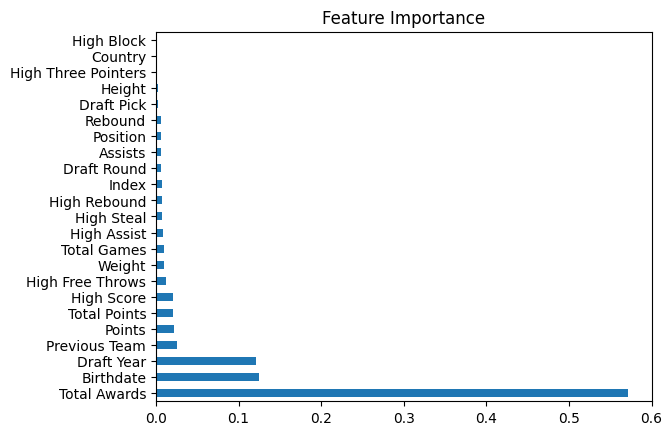

In [32]:
importance = dt.feature_importances_
importance_series = pd.Series(importance, index=X.columns)
sorted_importance = importance_series.sort_values(ascending=False)
sorted_importance.plot(kind='barh', title='Feature Importance')

<br/>
<br/>

**Cross Validation**
* Using 5-fold cross validation to confirm that there is no over-fitting in our model
* As you can see the deviation is very small, which means that there is probably no overfitting and the model is performing well.

In [56]:
model = LogisticRegression(max_iter=10000)

# Perform 5-fold cross-validation
scores = cross_validate(model, X_resampled, y_resampled, cv=5,
                        scoring=['accuracy', 'precision', 'recall', 'f1'])

# Print the mean scores and the 95% confidence intervals
for metric in scores.keys():
    if metric.startswith('test_'):
        mean = scores[metric].mean()
        std = scores[metric].std()
        print(f'{metric[5:]}: {mean:.2f} (+/- {std * 2:.2f})')

accuracy: 0.95 (+/- 0.02)
precision: 0.86 (+/- 0.07)
recall: 0.85 (+/- 0.08)
f1: 0.85 (+/- 0.06)
